In this note we will use Pretrained Model from TensorFlow Hub on Food vision Dataset and Will Extract some features from them.

1.   RestNet
2.   EfficientNet
3.   MobileNet




But First you can ask me a question that what is Transfer Learning?:

# Transfer Learning

A technique in machine learning where we use a pretrained that was trained for a specific task and will use it on other task.




> Transfer learning and domain adaptation refer to the situation where what has been learned in one setting … is exploited to improve generalization in another setting

Book: Deep Learning Page 526

https://machinelearningmastery.com/transfer-learning-for-deep-learning/





In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-07-04 12:29:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.128, 173.194.196.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   225MB/s    in 0.7s    

2022-07-04 12:29:18 (225 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

Create a generator to load images from directory

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data= train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [5]:
train_images, train_labels = next(train_data)

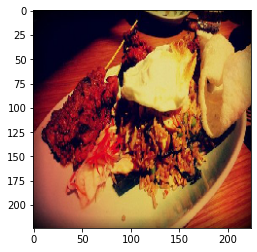

In [6]:
plt.imshow(train_images[0])
plt.show()

Steps to use pretrained model TensorFlow Hub.

1)Go to [TensorFlowHub](https://tfhub.dev/) Website

2) Choose the pretrained model for your specific type of problem. For example here i am using Image Dataset i'll go for images.

3) Copy the URL of Model

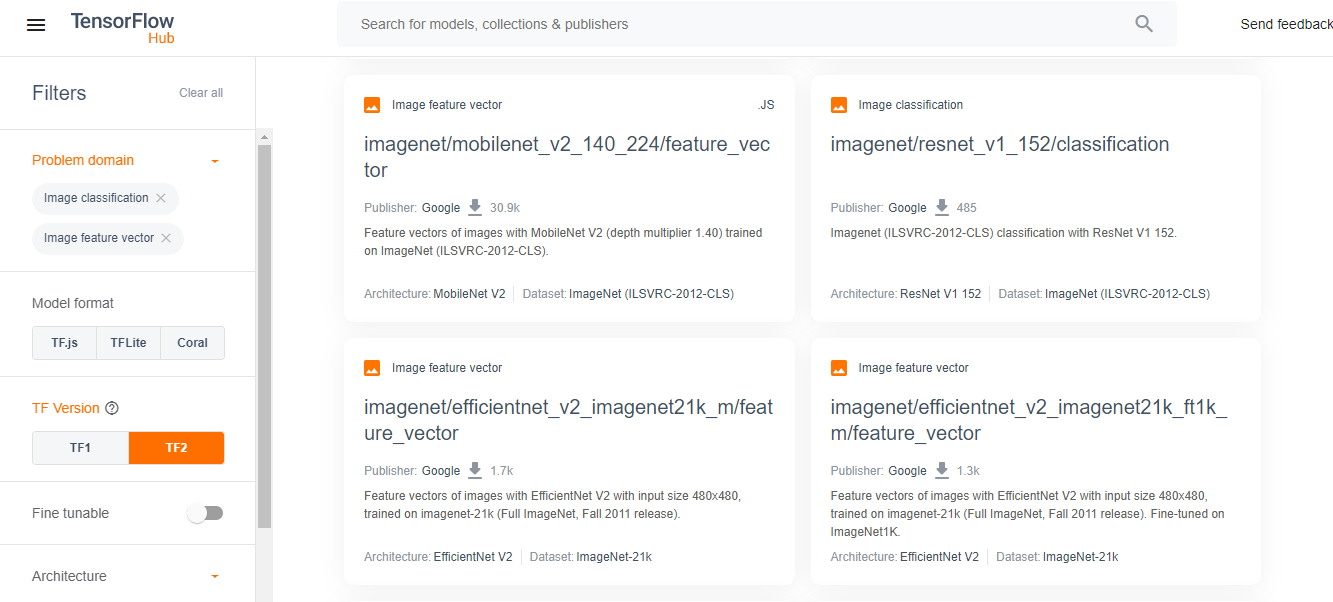

Copy URL

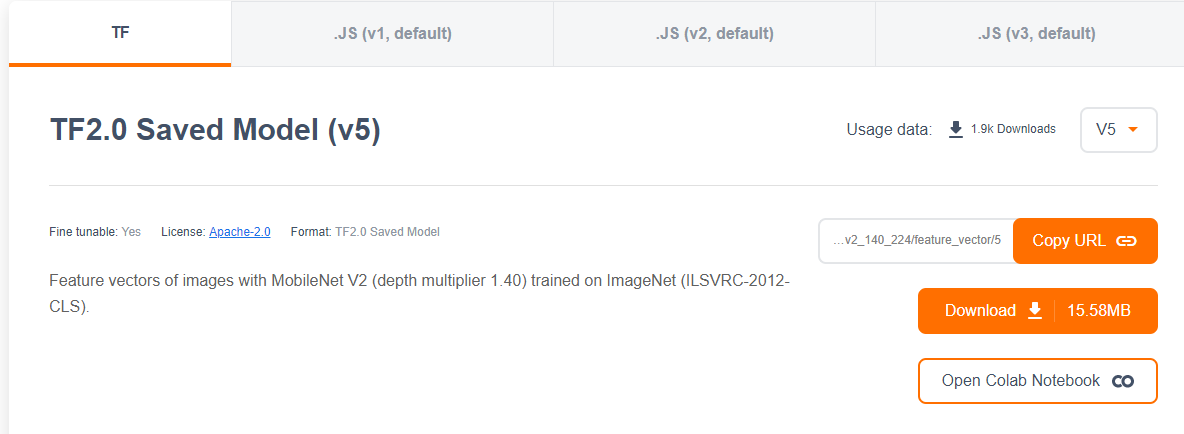

Before working with any model let me give an understanding about different types of Transfer Learning.


1) **As is transfer learning:**

When you use a pretrained model without making any changes to it for example we have a pretrained model trained on 1000 labels and if our problem also have 1000 labels so we use the model without making any changes to it.

2) **Feature Extraction Transfer Learning:**

If our problem has less labels than the pretrained which we are using then we simply change the input layer structure and also Output layer.
Example: We have 10 labels in our problem and the pretrained model is predicting 1000 labels than we simply make changes into the output layer.

3) **Fine Tuning Transfer Learning:** 

I will again use a pretrained but now tweak not only output layer but also some initial layers of our network. 

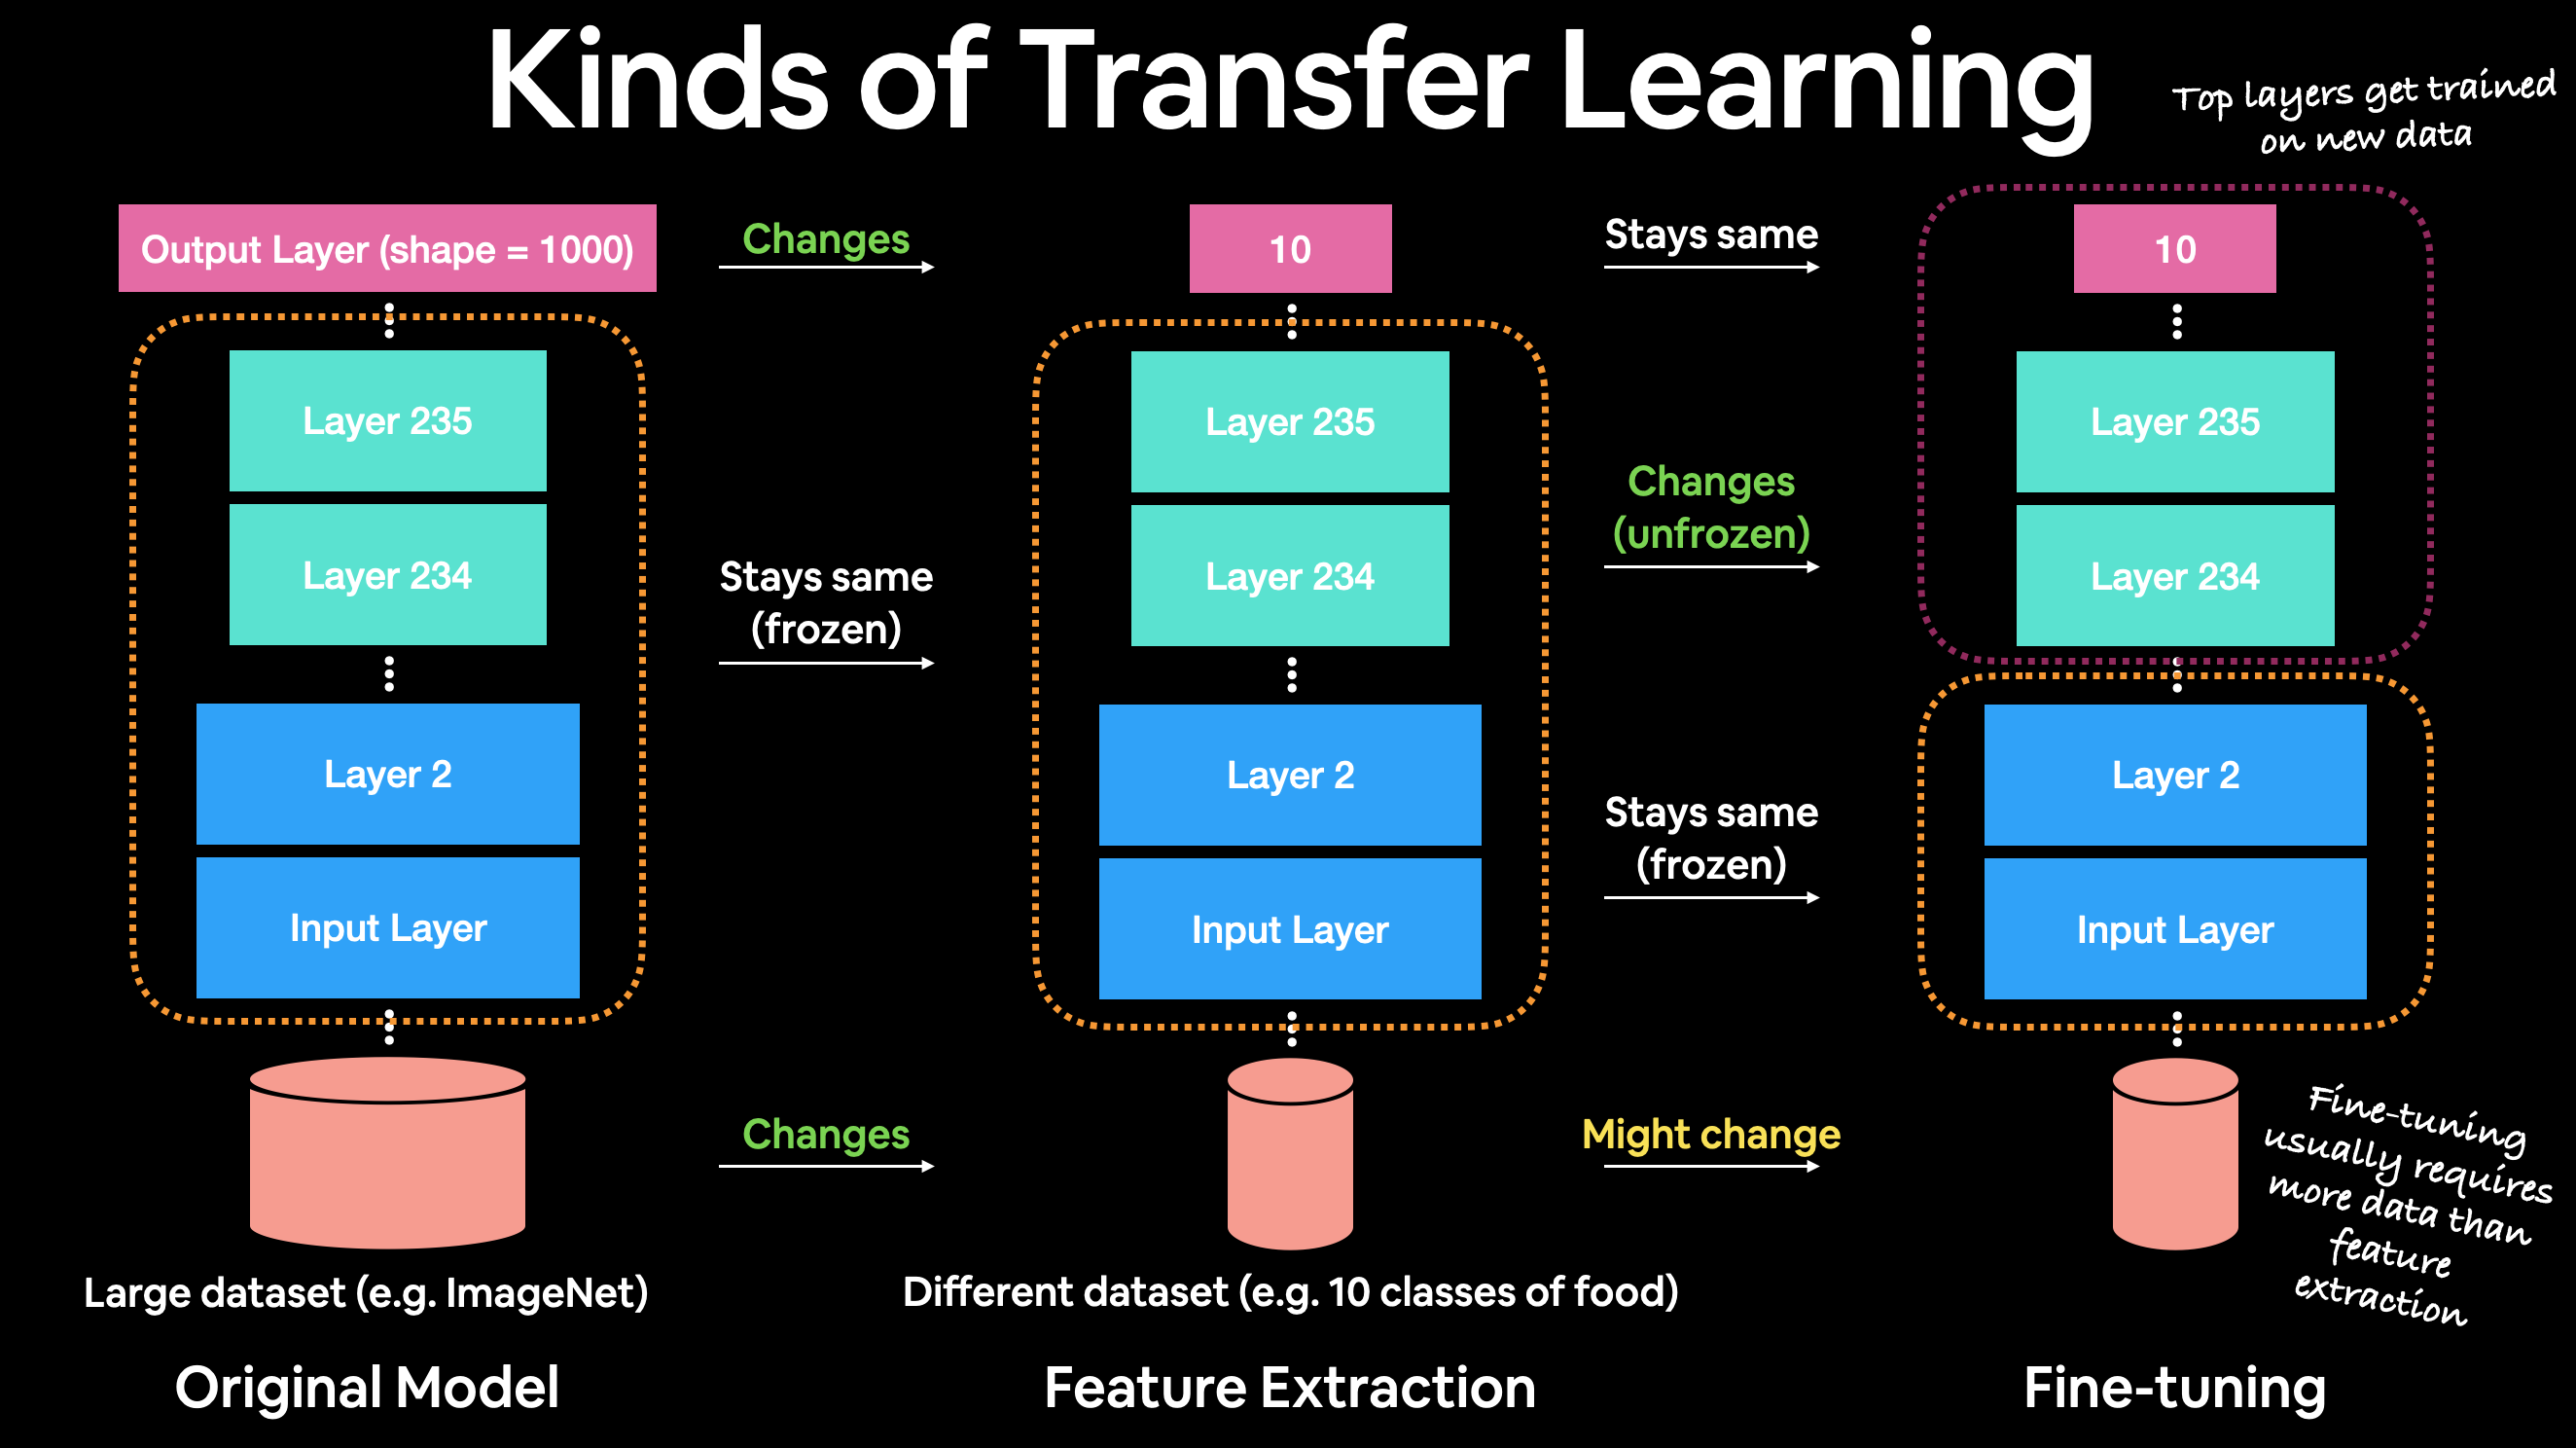


By : Daniel Bourke

## RestNet

In [10]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [11]:
def create_model(model_url, num_classes=10):
  
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # Freeze the Inner layers of model
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [12]:
# Create model
resnet_model = create_model(resnet_url, num_classes=10)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [15]:
# Resnet summary 
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [13]:
# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  batch_size=24,
                                  epochs=10,
                                  validation_data=test_data,
                                  )

Epoch 1/10
24/24 [==============================] - 31s 766ms/step - loss: 1.9387 - accuracy: 0.3240 - val_loss: 1.2051 - val_accuracy: 0.6240
Epoch 2/10
24/24 [==============================] - 16s 672ms/step - loss: 0.9192 - accuracy: 0.7373 - val_loss: 0.8357 - val_accuracy: 0.7424
Epoch 3/10
24/24 [==============================] - 17s 717ms/step - loss: 0.6245 - accuracy: 0.8280 - val_loss: 0.7317 - val_accuracy: 0.7684
Epoch 4/10
24/24 [==============================] - 16s 696ms/step - loss: 0.4966 - accuracy: 0.8707 - val_loss: 0.6907 - val_accuracy: 0.7804
Epoch 5/10
24/24 [==============================] - 18s 772ms/step - loss: 0.3841 - accuracy: 0.9160 - val_loss: 0.6533 - val_accuracy: 0.7936
Epoch 6/10
24/24 [==============================] - 18s 761ms/step - loss: 0.3156 - accuracy: 0.9387 - val_loss: 0.6416 - val_accuracy: 0.7956
Epoch 7/10
24/24 [==============================] - 17s 717ms/step - loss: 0.2689 - accuracy: 0.9547 - val_loss: 0.6351 - val_accuracy: 0.7964

In [17]:
# Plot the validation and training data separately
def plot_loss(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

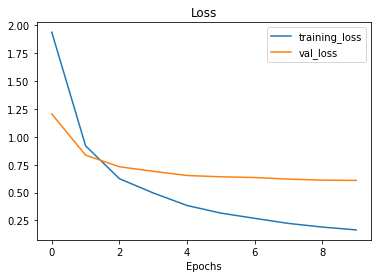

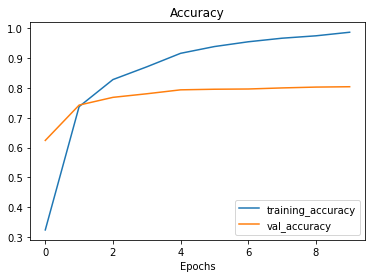

In [19]:
plot_loss(resnet_history)

## Efficient Net Model

In [35]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [36]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=10)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])


efficientnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [21]:
# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data, 
                                              epochs=10,
                                              batch_size=24,  
                                              validation_data=test_data,
                                            )

Epoch 1/10
24/24 [==============================] - 29s 708ms/step - loss: 1.8684 - accuracy: 0.4187 - val_loss: 1.3054 - val_accuracy: 0.7316
Epoch 2/10
24/24 [==============================] - 15s 642ms/step - loss: 1.0689 - accuracy: 0.7627 - val_loss: 0.8681 - val_accuracy: 0.8244
Epoch 3/10
24/24 [==============================] - 16s 672ms/step - loss: 0.7583 - accuracy: 0.8307 - val_loss: 0.7019 - val_accuracy: 0.8388
Epoch 4/10
24/24 [==============================] - 15s 638ms/step - loss: 0.6118 - accuracy: 0.8680 - val_loss: 0.6089 - val_accuracy: 0.8568
Epoch 5/10
24/24 [==============================] - 17s 740ms/step - loss: 0.5157 - accuracy: 0.8907 - val_loss: 0.5581 - val_accuracy: 0.8644
Epoch 6/10
24/24 [==============================] - 18s 753ms/step - loss: 0.4473 - accuracy: 0.9107 - val_loss: 0.5214 - val_accuracy: 0.8684
Epoch 7/10
24/24 [==============================] - 16s 694ms/step - loss: 0.3939 - accuracy: 0.9187 - val_loss: 0.4939 - val_accuracy: 0.8712

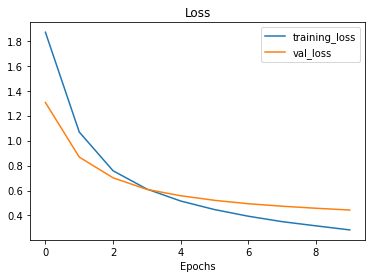

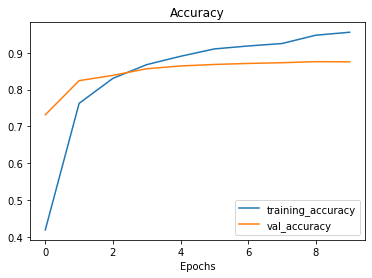

In [22]:
plot_loss(efficientnet_history)

## MobileNet

In [32]:
mobile_net_url= 'https://tfhub.dev/google/imagenet/mobilenet_v1_025_192/feature_vector/5'

# Create model
mobilenet_model = create_model(model_url=mobile_net_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=10)

# Compile EfficientNet model
mobilenet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])


mobilenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 256)              218544    
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                2570      
                                                                 
Total params: 221,114
Trainable params: 2,570
Non-trainable params: 218,544
_________________________________________________________________


In [33]:
mobilenet_history = mobilenet_model.fit(train_data, epochs=10, batch_size=24, validation_data=test_data)

Epoch 1/10
24/24 [==============================] - 16s 603ms/step - loss: 2.6056 - accuracy: 0.1373 - val_loss: 2.3196 - val_accuracy: 0.1784
Epoch 2/10
24/24 [==============================] - 13s 577ms/step - loss: 2.1374 - accuracy: 0.2520 - val_loss: 2.0174 - val_accuracy: 0.2792
Epoch 3/10
24/24 [==============================] - 13s 576ms/step - loss: 1.8740 - accuracy: 0.3440 - val_loss: 1.8177 - val_accuracy: 0.3700
Epoch 4/10
24/24 [==============================] - 13s 576ms/step - loss: 1.6737 - accuracy: 0.4133 - val_loss: 1.6675 - val_accuracy: 0.4204
Epoch 5/10
24/24 [==============================] - 13s 572ms/step - loss: 1.5201 - accuracy: 0.5173 - val_loss: 1.5373 - val_accuracy: 0.4752
Epoch 6/10
24/24 [==============================] - 13s 573ms/step - loss: 1.4033 - accuracy: 0.5533 - val_loss: 1.4561 - val_accuracy: 0.5072
Epoch 7/10
24/24 [==============================] - 13s 569ms/step - loss: 1.3044 - accuracy: 0.6027 - val_loss: 1.3978 - val_accuracy: 0.5344

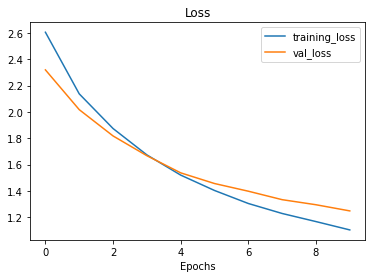

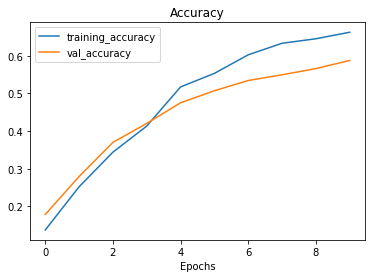

In [34]:
plot_loss(mobilenet_history)